# Simulated DCA Demo

In [1]:
from hyppo.tools import SIMULATIONS
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pickle

import dist_cov as dc

In [2]:
np.random.seed(7)

# 1D Simulated Linear Independence Data
## Plot Dataset

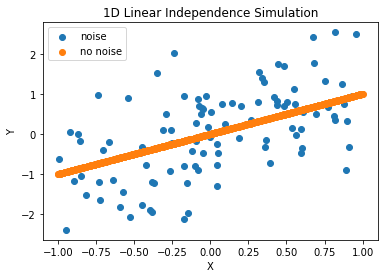

In [3]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("1D Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

## Initialize Data

In [4]:
X, Y = lin_sim(10, 1, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u_normalized_norm = LA.norm(dc.normalize_u(u))
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_normalized_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (10, 1)
Y shape: (10, 1)
u: [0.54173844]
u norm: 1.0


/home/db202/anaconda3/envs/hyppo/lib/python3.9/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "dist_cov.py", line 84:
@njit(parallel=True)
def dist_mat_u(u, X):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


## Test Function Dimension Alignment

In [5]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [-15.3747041]
v^2: 1.0508070803437908


## Optimize $u$

In [6]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-4, 1e-6)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.5692625924017901
u opt: [1.]
v^2_u_opt: 1.0508070803437908


## Plot Gradient Ascent

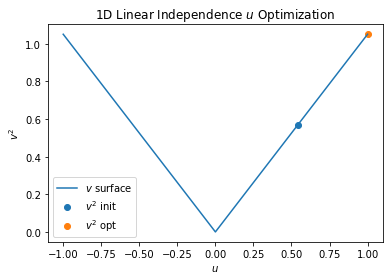

In [7]:
u_plt = np.expand_dims(np.linspace(-1, 1, 11), 1)
v_u_plt = np.zeros_like(u_plt)
for i in range(u_plt.shape[0]):
    D_u_i = dc.dist_mat_u(u_plt[i], X)
    R_X_u_i = dc.re_centered_dist(D_u_i)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt[i] = v_u_i
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_opt])
plt.xlabel(r"$u$")
plt.ylabel(r"$v^2$")
plt.title(r"1D Linear Independence $u$ Optimization")
plt.legend([r'$v$ surface', r'$v^2$ init', r'$v^2$ opt']);

# 2D Simulated Linear Independence Data
## Plot Dataset

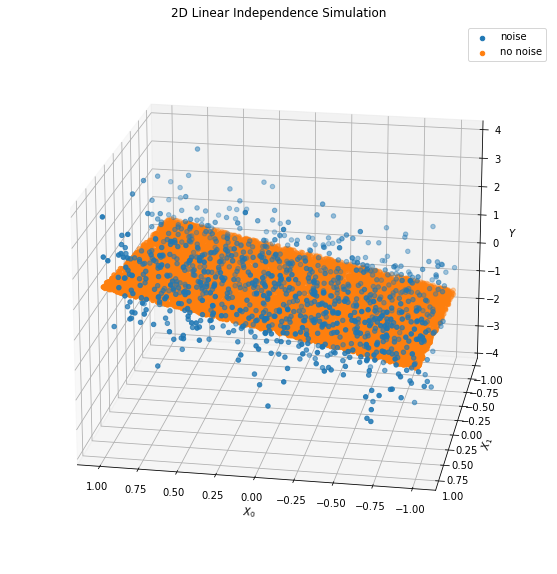

In [8]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(1000, 2, noise=True)
lin_x, lin_y = lin_sim(10000, 2)

lin_x_1_n = lin_x_n[:, 0]
lin_x_2_n = lin_x_n[:, 1]
lin_x_1 = lin_x[:, 0]
lin_x_2 = lin_x[:, 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(lin_x_1_n, lin_x_2_n, lin_y_n)
ax.scatter(lin_x_1, lin_x_2, lin_y)
ax.set_xlabel(r"$X_0$")
ax.set_ylabel(r"$X_1$")
ax.set_zlabel(r"$Y$")
plt.title("2D Linear Independence Simulation")
plt.legend(["noise", "no noise"])
ax.view_init(elev=20, azim=100);

## Initialize Data

In [9]:
X, Y = lin_sim(10, 2, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (10, 2)
Y shape: (10, 1)
u: [0.69506295 0.71894888]
u norm: 0.9999999999999999


## Test Function Dimension Alignment

In [10]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [ -9.68952104 -12.34180381]
v^2: 1.4171481000137327


## Optimize $u$

In [11]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-4, 1e-6)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.9784084743824661
u opt: [0.8260823  0.56354949]
v^2_u_opt: 0.9485942331055338


## Plot Gradient Ascent

In [12]:
surf_res = 1e-1
X_surf = np.arange(-1, 1, surf_res)
Y_surf = np.arange(-1, 1, surf_res)
X_surf, Y_surf = np.meshgrid(X_surf, Y_surf)
v_u_plt = np.zeros_like(X_surf)
for i in range(X_surf.shape[0]):
    for j in range(X_surf.shape[1]):
        D_u_i = dc.dist_mat_u(np.array([X_surf[i, j], Y_surf[i, j]]), X)
        R_X_u_i = dc.re_centered_dist(D_u_i)
        v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
        v_u_plt[i, j] = v_u_i

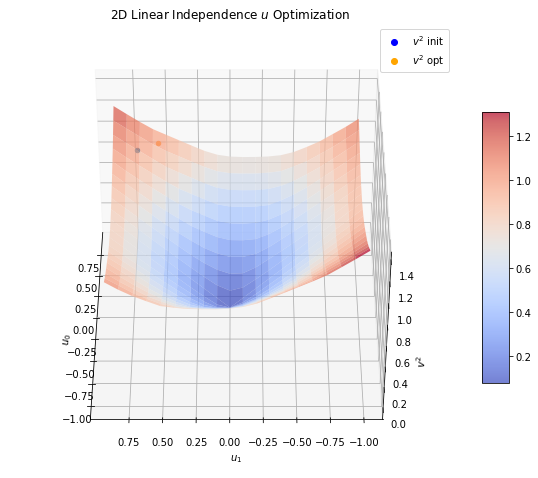

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(X_surf, Y_surf, v_u_plt, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=.7)
ax.scatter([u[0]], [u[1]], [v_u])
ax.scatter([u_opt[0]], [u_opt[1]], [v_opt])
ax.set_xlabel(r"$u_0$")
ax.set_ylabel(r"$u_1$")
ax.set_zlabel(r"$v^2$")
ax.set_title(r"2D Linear Independence $u$ Optimization")
init_proxy = Line2D([0], [0], linestyle="none", c='blue', marker='o')
opt_proxy = Line2D([0], [0], linestyle="none", c='orange', marker='o')
ax.legend([init_proxy, opt_proxy], [r"$v^2$ init", r"$v^2$ opt"], numpoints=1)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(elev=40, azim=180);

# nD Simulated Linear Independence Data
## Initialize Data

In [14]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (100, 10)
Y shape: (100, 1)
u: [0.10426133 0.42920031 0.3953108  0.12206355 0.23937776 0.50981725
 0.49242371 0.2469993  0.09556955 0.06251302]
u norm: 0.9999999999999999


## Test Function Dimension Alignment

In [15]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.47796203 0.42212307 0.40159038 0.15001607 0.3052904  0.46763941
 0.42738529 0.1994008  0.45929943 0.07312964]
v^2: 3.9024194765308633


## Optimize $u$

In [ ]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-1, 1e-10)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 1.0277362961967498


## DCA

In [ ]:
print(f"X shape: {X.shape}")
print(f"X:\n{X[:5]}")
U, v_dca = dc.dca(X, Y, K=3, lr=1e-1, epsilon=1e-10)
print(f"U shape: {U.shape}")
print(f"U:\n{U}")
print(f"v shape: {v_dca.shape}")
print(f"v: {v_dca}")
X_reduced = X @ U
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_reduced:\n{X_reduced[:5]}")

# Projection

In [ ]:
# k_pt = 1
# X_pt = np.array([5, 1])
# X_pt = X_pt / LA.norm(X_pt)
# U_pt = np.array([1, 2])
# U_pt = U_pt / LA.norm(U_pt)
# U_pt = np.expand_dims(U_pt, 0)
# q_pt = LA.qr(U_pt[:, :k_pt])
# X_proj_pt = dc.proj_U(X_pt, U_pt, k_pt)
# print(q_pt)

In [ ]:
# x_range_pt = np.linspace(0, 1, 11)
# plt.plot(X_pt[0] * x_range_pt, X_pt[1] * x_range_pt)
# plt.plot(U_pt[:, 0] * x_range_pt, U_pt[:, 1] * x_range_pt)
# plt.plot(q_pt[0] * x_range_pt, q_pt[1] * x_range_pt)
# plt.plot(X_proj_pt[0] * x_range_pt, X_proj_pt[1] * x_range_pt)
# plt.legend(["X", "U", "q", "X proj"]);

# Replicate Figure 2 from Cowley

In [ ]:
def unit_vec(v):
    return v / LA.norm(v)

def vec_angle(v0, v1):
    """
    Radians
    """
    u0 = unit_vec(v0)
    u1 = unit_vec(v1)
    return np.arccos(np.clip(np.dot(u0, u1), -1., 1.))

def beta_angle(beta_hat, beta):
    """
    Mean of all beta_i vectors (P x 1)
    """
    angle = 0
    b = beta_hat.shape[1]
    for i in range(b):
        v0 = beta_hat[:, i]
        v1 = beta[:, i]
        angle += vec_angle(v0, v1)
    return angle / (N * b)

def generate_data(N, P, b, f):
    """
    N: number of samples
    P: number of features
    b: number of dimensions identified from dimensionality reduction
    f: degree of nonlinearity
    returns
        X: (P x N): (feature x sample)
        beta: (P x b), beta_i: (P x 1)
        Y: (b x N)
    """
    X = np.random.normal(size=(P, N))
    beta = np.random.normal(size=(P, b))
    beta, _ = LA.qr(beta)
    alpha = 8 * np.sqrt(50) * LA.norm(X, ord=np.inf) # normalization constant
    Y = np.zeros((b, N))
    for i in range(N):
        Y[:, i] = np.sin(2 * np.pi / alpha * f * beta.T @ X[:, i]) # (b x P) @ (P x 1) = (b x 1)
    return X, beta, Y

In [ ]:
N = 100 # sample
P = 5 # feature
b = 2 # number of dimensions identified from dimensionality reduction
trial_ct = 10
f_range = [1] + [i for i in range(10, 130, 10)] # degree of nonlinearity
beta_angles = np.zeros((trial_ct, len(f_range)))
for i in range(trial_ct):
    print(f"trial: {i}")
    for j, f in enumerate(f_range):
        X, beta, Y = generate_data(N, P, b, f)
        beta_hat, v_hat = dc.dca(X.T, Y.T, K=b, lr=1e-1, epsilon=1e-10)
        angle = beta_angle(beta_hat, beta)
        print(f"f: {f}")
        print(f"beta angle: {np.rad2deg(angle)} deg")
        beta_angles[i, j] = angle
with open("dca_betas.pickle", 'wb') as wf:
    pickle.dump(beta_angles, wf)

In [ ]:
with open("dca_betas.pickle", 'rb') as rf:
    beta_angles = pickle.load(rf)
plt.plot(f_range, np.mean(np.rad2deg(beta_angles), axis=0))
plt.title("Mean Error Angle as a Function of Nonlinearity")
plt.xlabel("f")
plt.ylabel("angle: beta_hat, beta (deg)")
plt.legend(["DCA"]);